In [76]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)


#### Biodiversity Project

This project will analyze data from two files: observations.csv and species_info.csv

`Observations.csv` compiles information about the scientific names of a species, the number of observations of that species in the past 7 days, and the park where the observations occurred. Variables:
- **scientific_name**
- **park_name**
- **observations**

`Species_info.csv` compiles information about all the different scientific names for species, the common names for these species, the category of the species, and the conservation status of the species. Variables:
- **category**
- **scientific_name**
- **common_names**
- **conservation_status**



In [39]:
species = pd.read_csv('/users/ghanimsial/desktop/Code Cademy/Data Science Machine Learning Specialist/Biodiversity Project/species_info.csv')
print(f'Shape of species: {species.shape}')
species.fillna(value = {'conservation_status': 'no intervention'}, inplace=True)
species.head()
# category
# scientific_name
# common_names
# conservation_status



Shape of species: (5824, 4)


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,no intervention
1,Mammal,Bos bison,"American Bison, Bison",no intervention
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",no intervention
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",no intervention
4,Mammal,Cervus elaphus,Wapiti Or Elk,no intervention


In [12]:
observations = pd.read_csv('/users/ghanimsial/desktop/Code Cademy/Data Science Machine Learning Specialist/Biodiversity Project/observations.csv')
print(f'Shape of observations: {observations.shape}')
observations.head()
# scientific_name
# park_name
# observations

Shape of observations: (23296, 3)


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


#### Objectives
- **Distribution of conservation_status across category**
- **Are certain types of species more likely to be endangered as compared to others?**
- **Which species were spotted the most at each park?**
- **Are the differences between species and their conservation status significant?**
- **Which park has a highest number of protected species?**


[Text(0, 0, 'Mammal'),
 Text(1, 0, 'Bird'),
 Text(2, 0, 'Reptile'),
 Text(3, 0, 'Amphibian'),
 Text(4, 0, 'Fish'),
 Text(5, 0, 'Vascular Plant'),
 Text(6, 0, 'Nonvascular Plant')]

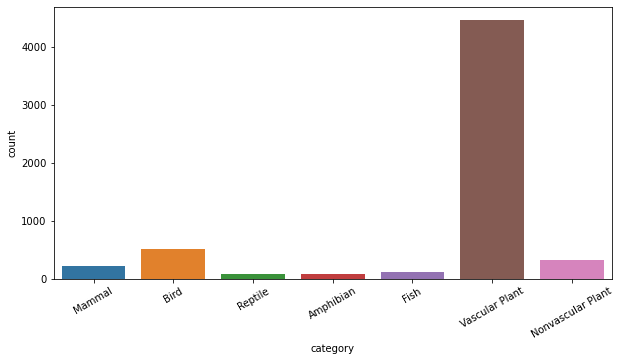

In [38]:
species.conservation_status.unique()
plt.figure(figsize = (10,5))
ax = sns.countplot(data = species, x = species.category)
ax.set_xticklabels(labels = species.category.unique(), rotation = 30)

5541

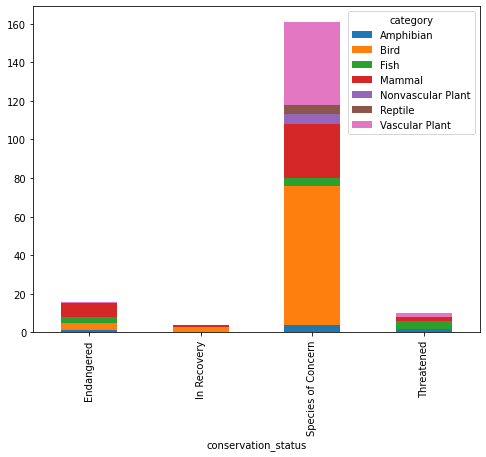

In [58]:
cat_cons = species[species['conservation_status'] != 'no intervention'].groupby(['conservation_status', 'category']).scientific_name.count().unstack()
cat_cons.plot(kind = 'bar', stacked = True, figsize = (8,6))


In [118]:
species['is_protected'] = species['conservation_status'] != 'no intervention'
category_counts = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index().pivot(columns = 'is_protected', index = 'category', values = 'scientific_name').reset_index()
category_counts.columns = ['category', 'not protected', 'protected']
category_counts['protection_percentage'] = np.round(100*category_counts.protected/(category_counts['not protected']+category_counts.protected), 2)
category_counts


,category,not protected,protected,protection_percentage
0,Amphibian,72,7,8.86
1,Bird,413,75,15.37
2,Fish,115,11,8.73
3,Mammal,146,30,17.05
4,Nonvascular Plant,328,5,1.50
5,Reptile,73,5,6.41
6,Vascular Plant,4216,46,1.08
